In [1]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state=42)

In [14]:
# Make dataframe of circle data

import pandas as pd

circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label":y})
circles

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


In [15]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

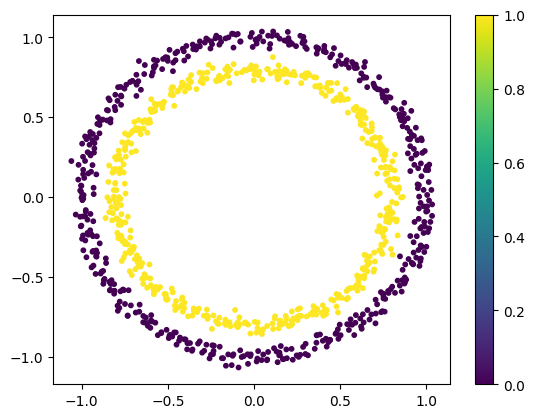

In [ ]:
import matplotlib.pyplot as plt



plt.scatter(X[:,0],
            X[:,1],
            c=y,
            s=10)
plt.colorbar()
plt.show()

In [26]:
import torch

X= torch.from_numpy(X).type(torch.float)
y= torch.from_numpy(y).type(torch.float)

In [28]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [30]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

In [31]:
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [177]:
import torch.nn.functional as F

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features=64)
        self.layer_2 = nn.Linear(in_features = 64, out_features=32)
        self.layer_3 = nn.Linear(in_features = 32, out_features=16)
        self.layer_4 = nn.Linear(in_features = 16, out_features=1)
        
    def forward(self, X):
        X= F.relu(self.layer_1(X))
        X= F.relu(self.layer_2(X))
        X= F.relu(self.layer_3(X))
        return self.layer_4(X)

In [178]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [217]:
torch.manual_seed(42)
model_v1 = CircleModelV0().to(device)

In [218]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_v1.parameters(),
                            lr=0.01)

In [219]:


X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [222]:
epochs =15

In [223]:
for epoch in range(epochs):
    
    model_v1.train()
    y_logits = model_v1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_pred=y_pred, y_true=y_train)
    
    optimizer.zero_grad()
    
    loss.backward()
    optimizer.step()
    
    model_v1.eval()
    
    with torch.inference_mode():
        test_logits = model_v1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = accuracy_fn(y_pred=test_pred, y_true=y_test)
        
    # Print out what's happening every 10 epochs
    if epoch % 2 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_accuracy:.2f}%")  


Epoch: 0 | Loss: 0.64124, Accuracy: 62.38% | Test loss: 0.64623, Test acc: 59.50%
Epoch: 2 | Loss: 0.61096, Accuracy: 78.75% | Test loss: 0.61472, Test acc: 77.00%
Epoch: 4 | Loss: 0.56963, Accuracy: 83.62% | Test loss: 0.57374, Test acc: 82.50%
Epoch: 6 | Loss: 0.51473, Accuracy: 96.50% | Test loss: 0.51809, Test acc: 90.50%
Epoch: 8 | Loss: 0.44800, Accuracy: 98.38% | Test loss: 0.44900, Test acc: 97.00%
Epoch: 10 | Loss: 0.37131, Accuracy: 98.88% | Test loss: 0.37509, Test acc: 98.50%
Epoch: 12 | Loss: 0.29357, Accuracy: 99.38% | Test loss: 0.30132, Test acc: 99.50%
Epoch: 14 | Loss: 0.22274, Accuracy: 99.38% | Test loss: 0.23394, Test acc: 99.50%


In [224]:
from torch import inference_mode


with inference_mode():
    y_logit= model_v1(X_test.to(device)).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logit))
    
accuracy_fn(y_pred=y_pred,y_true=y_test) 

99.5

In [ ]:
import numpy


def generate_plot(X1 = None, X2=None, y=None):
    X1 = X1.detach().cpu().numpy()
    X2 = X2.detach().cpu().numpy()
    y= y.detach().cpu().numpy()
    plt.scatter(X1,X2,c=y, s=10)
    plt.colorbar()
    plt.show()

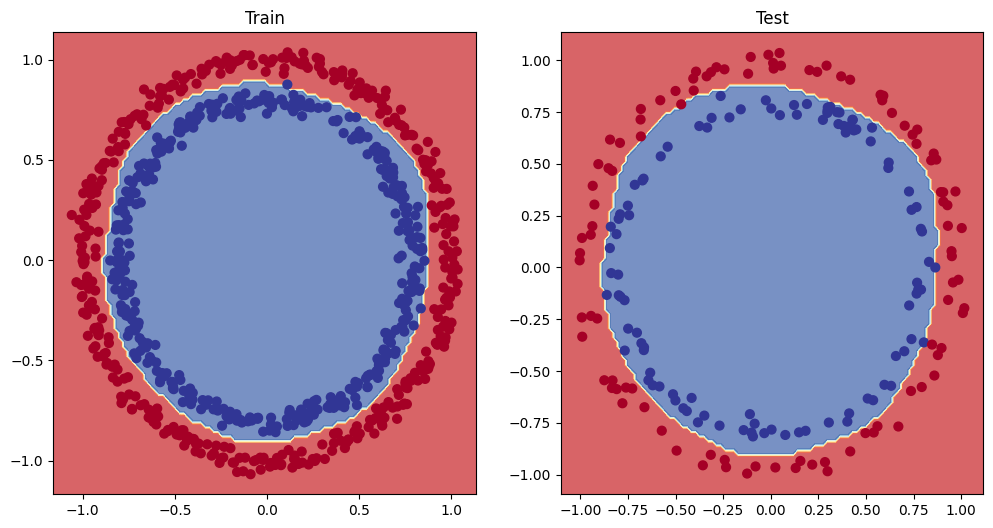

In [225]:
from helper_functions import plot_decision_boundary

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_v1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_v1, X_test, y_test)

In [163]:
c=0
d=0
for r in y_test:
    if r == 0:
        c+=1
    else: 
        d+=1
print(c,":0")
print(d,":1")

100 :0
100 :1


## Multiclass Pytorch Model

In [106]:
import torch
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [107]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [108]:
X, y = make_blobs(n_samples=1000,
                  n_features=2,
                  centers=NUM_CLASSES,
                  cluster_std=1.5,
                  random_state=RANDOM_SEED)

In [109]:
X[:5],y[:5]

(array([[-8.41339595,  6.93516545],
        [-5.76648413, -6.43117072],
        [-6.04213682, -6.76610151],
        [ 3.95083749,  0.69840313],
        [ 4.25049181, -0.28154475]]),
 array([3, 2, 2, 1, 1]))

In [110]:
X.shape, y.shape

((1000, 2), (1000,))

In [111]:
X_blob = torch.from_numpy(X).type(torch.float)
y_blob = torch.from_numpy(y).type(torch.long)

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X_blob,y_blob, random_state=RANDOM_SEED, test_size=0.2)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

In [113]:
def generate_plot(X1=None, y=None,X2=None):
    plt.scatter(X1,X2,c=y, s=20)
    plt.show()

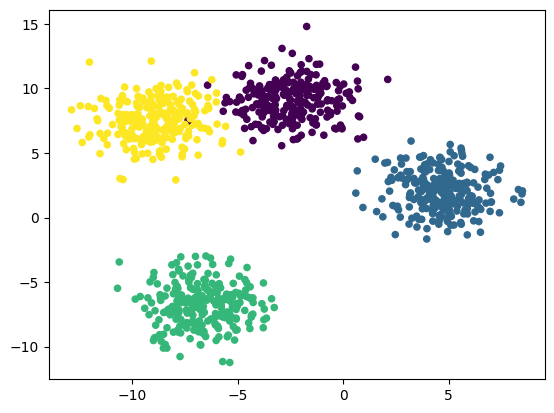

In [114]:
generate_plot(X[:,0],y,X[:,1])

In [115]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [116]:
import torch.nn as nn
import torch.optim as optim

In [117]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_layers=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_layers),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_layers, out_features=hidden_layers),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_layers, out_features=output_features),
        )
        
    def forward(self, X):
        return self.linear_layer_stack(X)

In [118]:
model_v0= BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES,
                    hidden_layers=10).to(device)

model_v0

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [119]:
loss_fn= nn.CrossEntropyLoss()
optimizer=optim.SGD(params= model_v0.parameters(),
                    lr=0.01)

In [120]:
model_v0(X_test.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [121]:
epochs = 100

In [122]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [123]:
y_train.device, y_train.dtype, y_train.shape

(device(type='cuda', index=0), torch.int64, torch.Size([800]))

In [127]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_true))
    return acc

In [128]:
for epoch in range(epochs):
    #training
    model_v0.train()
    y_logits= model_v0(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true= y_train, y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
    #evaluating
    model_v0.eval()
    with torch.inference_mode():
         # 1. Forward pass
        test_logits = model_v0(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # 2. Calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_pred =test_pred, y_true=y_test)
    
    
     # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.14292, Acc: 0.99% | Test Loss: 0.13901, Test Acc: 0.99%
Epoch: 10 | Loss: 0.13277, Acc: 0.99% | Test Loss: 0.12885, Test Acc: 0.99%
Epoch: 20 | Loss: 0.12402, Acc: 0.99% | Test Loss: 0.12004, Test Acc: 0.99%
Epoch: 30 | Loss: 0.11641, Acc: 0.99% | Test Loss: 0.11233, Test Acc: 0.99%
Epoch: 40 | Loss: 0.10973, Acc: 0.99% | Test Loss: 0.10554, Test Acc: 0.99%
Epoch: 50 | Loss: 0.10385, Acc: 0.99% | Test Loss: 0.09953, Test Acc: 0.99%
Epoch: 60 | Loss: 0.09862, Acc: 0.99% | Test Loss: 0.09417, Test Acc: 0.99%
Epoch: 70 | Loss: 0.09396, Acc: 0.99% | Test Loss: 0.08938, Test Acc: 0.99%
Epoch: 80 | Loss: 0.08978, Acc: 0.99% | Test Loss: 0.08507, Test Acc: 0.99%
Epoch: 90 | Loss: 0.08602, Acc: 0.99% | Test Loss: 0.08117, Test Acc: 0.99%


In [129]:
with torch.inference_mode():
    test_logits = model_v0(X_test)
    

In [131]:
test_pred= torch.softmax(test_logits, dim=1).argmax(dim=1)

In [132]:
# Compare first 10 model preds and test labels
print(f"Predictions: {test_pred[:10]}\nLabels: {y_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_test, y_pred=test_pred)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 0.995%


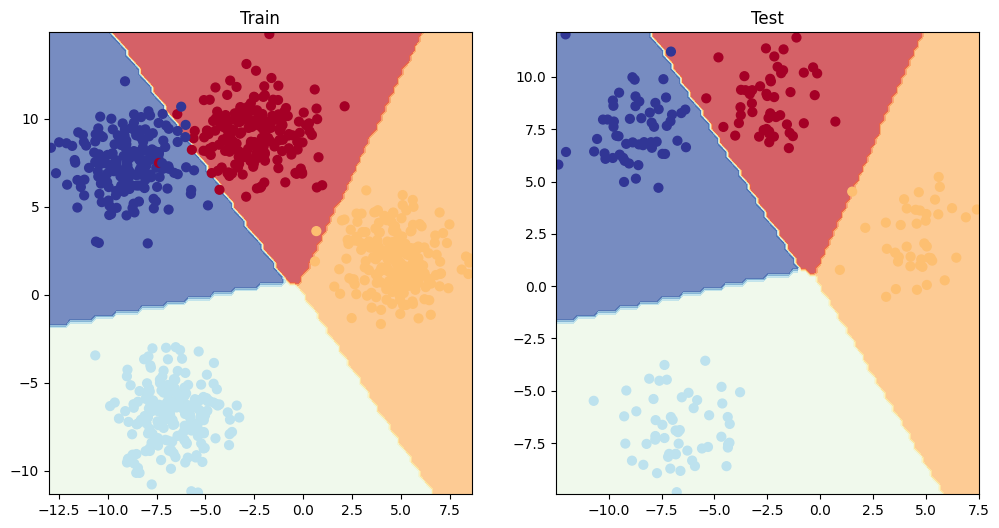

In [133]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_v0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_v0, X_test, y_test)

In [135]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(test_pred, y_test)

tensor(0.9950, device='cuda:0')

In [136]:
from sklearn import multiclass
from torchmetrics import F1Score

f1 = F1Score(task= "multiclass", num_classes=4).to(device)
f1(test_pred, y_test)

tensor(0.9950, device='cuda:0')